In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
# ====================== THREADING SETUP ======================
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"

# restrict GPUs
tf.config.set_visible_devices([], 'GPU')
# set threading
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(4)

# ====================== FILTER FUNCTIONS ======================

def bandpass_emg(x, fs, low=20, high=450, order=4):
    """4th-order Butterworth bandpass filter"""
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, x, axis=0)


def notch_emg(x, fs, freq=50.0, Q=30):
    """IIR notch filter at specified frequency"""
    b, a = iirnotch(freq/(0.5*fs), Q)
    return filtfilt(b, a, x, axis=0)


def baseline_correct(x):
    """Subtract mean to center signal"""
    return x - np.mean(x, axis=0)


# ====================== CONFIGURATION ======================
subject = 1
Left = True
train_files = []
for i in range(3,13):
    if Left and i % 2 == 0:
        train_files.append(f"parsed_emg/subject_{subject}/trial_{i}(left).csv")
    if not Left and i % 2 == 1:
        train_files.append(f"parsed_emg/subject_{subject}/trial_{i}(right).csv")

test_file = (
    f"parsed_emg/subject_{subject}/trial_2(left).csv" if Left else
    f"parsed_emg/subject_{subject}/trial_1(right).csv"
)

label_col = 5
batch_size = 64
learning_rate = 1e-3
epochs = 1
num_classes = 3
window_size = 40  # samples per window
step = 10         # sliding step
fs = 1240         # sampling rate in Hz (set according to your data)

# ====================== DATA LOADING & PREPROCESSING ======================

def load_and_preprocess(path):
    # load raw data
    df = pd.read_csv(path, skiprows=1)
    time = df.iloc[:,0].values.astype('float32').reshape(-1,1)
    emg = df.iloc[:,1:5].values.astype('float32')
    labels = df.iloc[:,label_col].values.astype('int32')

    # filtering
    emg = bandpass_emg(emg, fs)
    emg = notch_emg(emg, fs)

    # baseline correction
    emg = baseline_correct(emg)

    # normalize to [-1,1]
    scaler = MinMaxScaler(feature_range=(0,1))
    emg = scaler.fit_transform(emg)

    return emg, labels

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 40, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,483 (423.76 KB)

 Trainable params: 108,099 (422.26 KB)

 Non-trainable params: 384 (1.50 KB)

2990/2990 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.4539 - loss: 1.0297 - val_accuracy: 0.3464 - val_loss: 1.1107
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2805 - loss: 1.0616
Test accuracy: 0.2629, loss: 1.1289


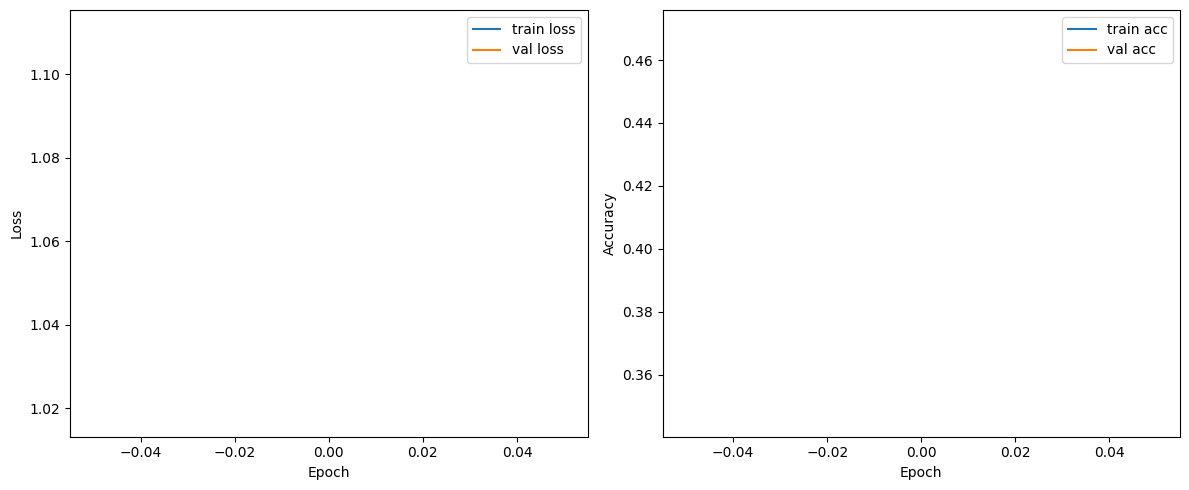

441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 640x480 with 0 Axes>

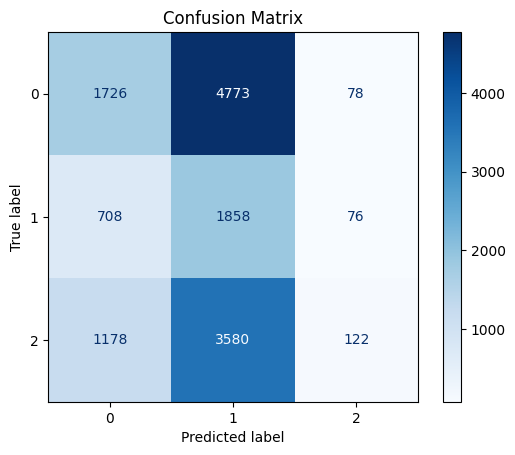

In [9]:
# accumulate windows across all training trials
X_windows_all, y_windows_all = [], []
for f in train_files:
    emg, y = load_and_preprocess(f)
    # sliding window
    for start in range(0, len(emg) - window_size + 1, step):
        seg = emg[start:start+window_size]
        lbl = np.argmax(np.bincount(y[start:start+window_size]))
        X_windows_all.append(seg)
        y_windows_all.append(lbl)

X_windows_all = np.array(X_windows_all)
y_windows_all = np.array(y_windows_all)

# stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X_windows_all, y_windows_all,
    test_size=0.2, random_state=42, stratify=y_windows_all
)

# ====================== MODEL DEFINITION ======================

def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 15, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv1D(128, 10, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model = build_model((window_size, 4))
model.summary()

# ====================== TRAINING ======================
# handle class imbalance
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: cw[i] for i in range(len(cw))}

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# ====================== EVALUATION ======================
# prepare test windows
emg_test, y_test = load_and_preprocess(test_file)
X_test_windows, y_test_windows = [], []
for start in range(0, len(emg_test) - window_size + 1, step):
    seg = emg_test[start:start+window_size]
    lbl = np.argmax(np.bincount(y_test[start:start+window_size]))
    X_test_windows.append(seg)
    y_test_windows.append(lbl)
X_test_windows = np.array(X_test_windows)
y_test_windows = np.array(y_test_windows)

loss, acc = model.evaluate(X_test_windows, y_test_windows)
print(f"Test accuracy: {acc:.4f}, loss: {loss:.4f}")

# ====================== PLOTS ======================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_windows).argmax(axis=1)
cm = confusion_matrix(y_test_windows, y_pred)
disp = ConfusionMatrixDisplay(cm)
plt.figure(); disp.plot(cmap=plt.cm.Blues); plt.title('Confusion Matrix'); plt.show()
